C:\Users\sOrOush\AppData\Local\Temp\ipykernel_183348\3770002112.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locatio

Datasets ready: 1212 train, 335 val, 205 test samples.

🎯 Final Test Accuracy: 97.56% (Loss: 0.0788)

Datasets ready: 1212 train, 335 val, 205 test samples.
Classification Report:

                                                             precision    recall  f1-score   support

                                            Bahnhofstraße 7      1.000     1.000     1.000         8
                                             Barfüßstraße 1      1.000     1.000     1.000         9
                                            Biegenstraße 11      1.000     1.000     1.000        10
                                            Biegenstraße 12      1.000     1.000     1.000         6
                                            Biegenstraße 14      0.857     1.000     0.923         6
                                             Biegenstraße 9      1.000     1.000     1.000         6
                                        Deutschhausstraße 1      1.000     1.000     1.000        11
Deutschhau

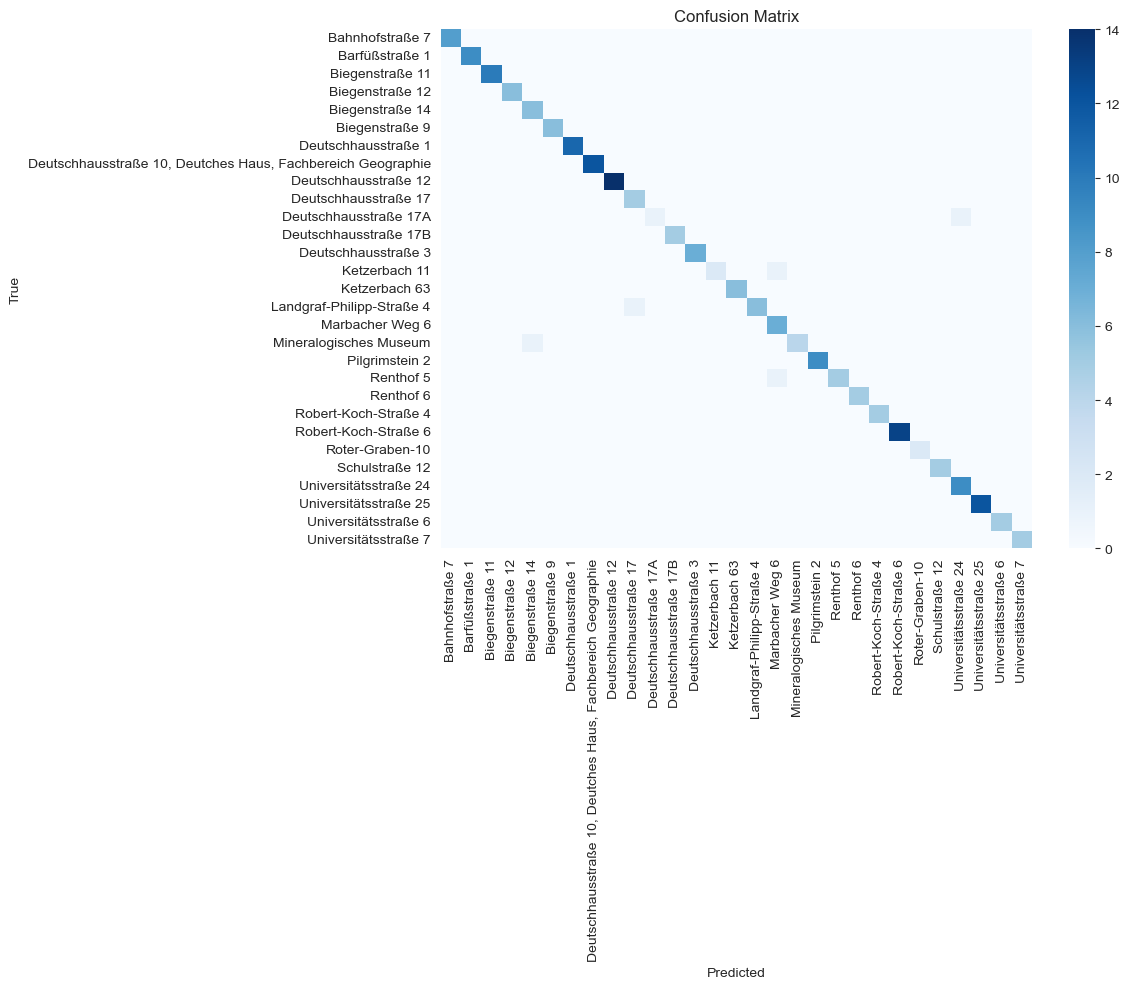

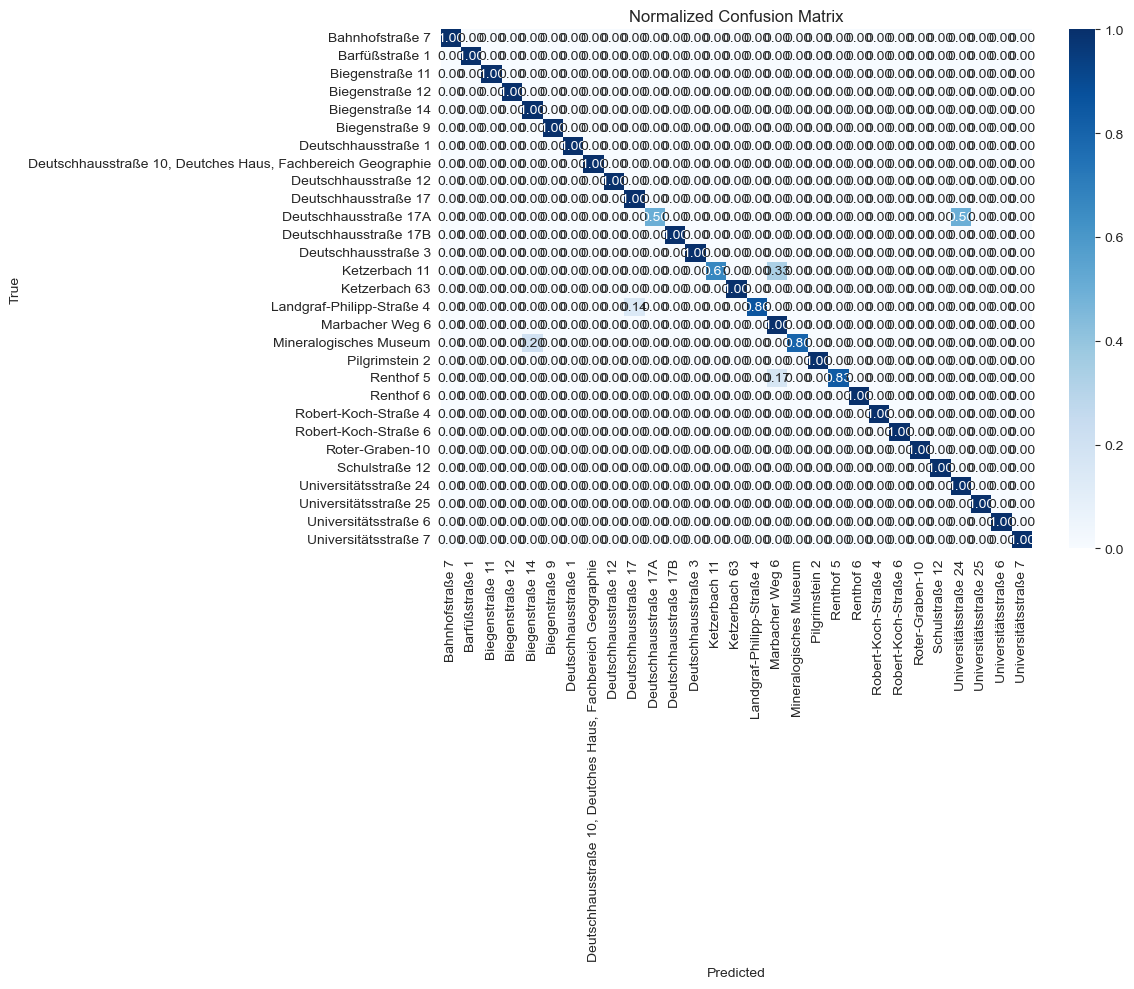

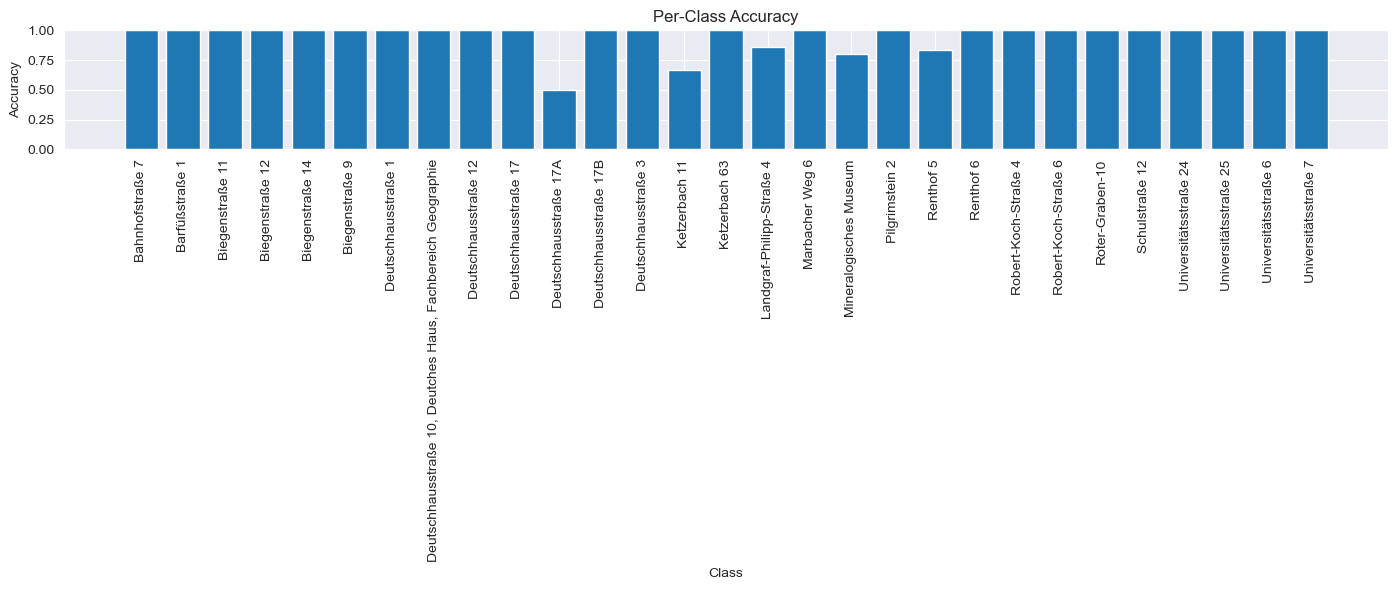

In [2]:
# Evaluate and Plot in Jupyter Notebook

import torch
import torch.nn as nn
from torchvision import models
from prepare_data import create_dataloaders
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----------------------
# CONFIGURATION
# ----------------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = 'resnet50_marburglens.pth'
NUM_CLASSES = 29
BATCH_SIZE = 32

# ----------------------
# FUNCTIONS
# ----------------------
def load_model(model_path):
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

def evaluate_testset(model):
    _, _, test_loader = create_dataloaders(batch_size=BATCH_SIZE)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    test_loss = running_loss / total
    test_acc = 100. * correct / total

    print(f"\n🎯 Final Test Accuracy: {test_acc:.2f}% (Loss: {test_loss:.4f})\n")
    return all_labels, all_preds

def plot_confusion_matrix(y_true, y_pred, class_names, normalized=False):
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalized else None)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=normalized, fmt='.2f' if normalized else 'd', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix' if normalized else 'Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_per_class_accuracy(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    plt.figure(figsize=(14,6))
    plt.bar(class_names, per_class_acc)
    plt.xticks(rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Per-Class Accuracy')
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

# ----------------------
# RUN EVERYTHING
# ----------------------

# Load model
model = load_model(MODEL_PATH)

# Evaluate
y_true, y_pred = evaluate_testset(model)

# Load class names
_, _, test_loader = create_dataloaders(batch_size=BATCH_SIZE)
class_names = test_loader.dataset.classes

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# Plot confusion matrix (standard)
plot_confusion_matrix(y_true, y_pred, class_names, normalized=False)

# Plot confusion matrix (normalized)
plot_confusion_matrix(y_true, y_pred, class_names, normalized=True)

# Plot per-class accuracy
plot_per_class_accuracy(y_true, y_pred, class_names)
